In [1]:
'''
Unsupervised k-means clustering on standardized and cleaned plain text file versions of EEBO-TCP texts. 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file made using metadata.py in Stage I. 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from functions import keywords


def vectorize(strings,ids,option):
    '''
    Vectorizes the texts and returns a dataframe of texts mapping to their TCP IDs. 
    '''
    # vector = TfidfVectorizer(min_df=2, sublinear_tf=True)
    # results = vector.fit_transform(strings)
    if option =='count': vector = CountVectorizer()
    else: vector = TfidfVectorizer()
    results = vector.fit_transform(strings)
    return pd.DataFrame(results.toarray(), index=ids, columns=vector.get_feature_names_out()) # Convert information back to a DataFrame

def cluster(df,ids,num):
    model = KMeans(n_clusters=num, random_state=42) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
    return kmeans_groups,model

def topTerms(model,df,num):
    print("Top terms per cluster:")
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = list(df.columns)
    for i in range(num):
        top = []
        for ind in centroids[i, :20]:
            top.append(terms[ind])
        print("Cluster %d:" % i,top)

def elbow(df):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), df, k=(2, 10),timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='calinski_harabasz',timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='silhouette',timings=False)
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance
    intercluster_distance(KMeans(num),model, embedding='mds') 

def pcaColors(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python \n",
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    label = kmeans.fit_predict(pca_results) 
    u_labels = np.unique(label)
    groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred'}
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()

def pca(df):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    pca_df = pd.DataFrame(pca_results, columns=["pc1","pc2"])
    pca_df.plot.scatter(x='pc1', y='pc2')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()


In [2]:
import os,re 
def getTexts(folder,searchList):
    fileToText = {}
    underscores = {}
    for root,dirs,files in os.walk(folder):
        for file in files:
                if '.txt' not in file: continue
                path = os.path.join(folder,file)
                f = open(path,'r')
                text = f.readlines()[0]
                if '_' in file: 
                        name = file.split('_')[0]
                        if name not in searchList: continue
                        if name not in underscores.keys(): 
                                underscores[name] = text
                        else: underscores[name] = underscores[name] + ' ' + text
                else: 
                        name = file.split('.')[0]
                        if name not in searchList: continue
                        fileToText[name] = text
                f.close()
        for name,text in underscores.items():
            fileToText[name] = text
        return fileToText

In [3]:
'''Get Topic Words for each text in a dictionary'''
readFile = open('/srv/data/periodFeatures/period1features/period1580topics.txt','r')
topics = {}
for line in readFile:
    tcpID =  line.split(':')[0].strip('.txt')
    topic = line.split(':')[1].strip()
    topic = re.sub(r' if | of | by | yet | the | man | see | and ',' ',topic)
    topic = re.sub('  ',' ',topic)
    topics[tcpID] = topic.split(' ')
readFile.close()
print(len(topics))

1905


In [5]:
'''Get additional features'''
inFile = open('/srv/data/periodFeatures/period1features/featuresPeriod1580.txt','r')
inFileLines = inFile.readlines()
inFile.close()
featuresDict = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip().split(' ')
    featuresDict[line[0].strip()] = features
print(len(featuresDict))

'''Get drug and tobacco features'''
tobacco = 'tobacco|tobaco|tobacca|tobacconist'
drug = 'drug|drugge|drugg|elixir|apothecary|confection|confect|medicinable|medicine|medecine|medicament|arsenic|poppy|chemic|medicinal|intoxicate|tacamahaca|potion|mithridate|antimony|opiate|opium'

inFile = open('/srv/data/periodFeatures/period1features/drugTobaccoPeriod1580.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoDrug = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip().split(' ')
    if features[0] == '': continue
    
    '''For specifically tobacco texts'''
    instances = re.findall(tobacco,' '.join(features))
    if len(instances) < 1: continue
    tobaccoDrug[line[0].strip()] = features
print(len(tobaccoDrug))

'''Get tobacco n-gram features'''
inFile = open('/srv/data/periodFeatures/period1features/period1tobaccongrams.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoNgrams = {}
for line in inFileLines: 
    line = line.split(':')
    features = line[1].strip()
    if features == '': continue
    tobaccoNgrams[line[0].strip()] = features.strip()
print(len(tobaccoNgrams))

1905
31
21


In [6]:
'''Get keywords metadata for each text in a dictionary'''
'''Create list of feature strings for each file and remove stopwords'''
import re 
from timePeriods import period1
features = {}
textInfo = getTexts('/srv/data/relevantEPBodySTOP',period1)
kwdict = keywords('/srv/data/metadata/tuning/relevant.csv')

for ID in tobaccoNgrams.keys():
    '''Skip the texts that do not have any mention of tobacco or drugs'''
    features[ID] = [textInfo[ID]]
    kWords = (list(kwdict[ID][0]))
    features[ID].append(' '.join(kWords*50))
    features[ID].append(' '.join(topics[ID]*50))
    features[ID].append(' '.join(featuresDict[ID]*20))
    features[ID].append(' '.join(tobaccoDrug[ID]*20))
    features[ID].append(' '.join(tobaccoNgrams[ID]*10))
    featureStr = ' '.join(features[ID])
    featureStr = re.sub(r' if | of | by | yet | the | man | see | and ',' ',featureStr)
    featureStr = re.sub('  ',' ',featureStr)
    features[ID] = featureStr
print(f'Total number of texts to classify is {len(features)}')

Total number of texts to classify is 21


In [7]:
print(list(features.keys()))

['A68946', 'A02775', 'A12777', 'A08015', 'A18402', 'A18770', 'A19797', 'A71324', 'A02655', 'A14160', 'A06183', 'A18419', 'A10710', 'A00991', 'A68945', 'A02495', 'A05458', 'A08003', 'A00410', 'A19921', 'A04813']


/home/acw77/miniconda3/lib/python3.9/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/acw77/miniconda3/lib/python3.9/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['san

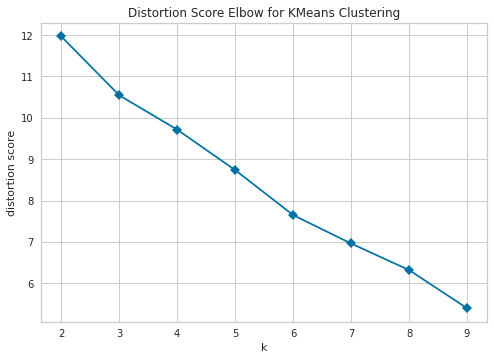

In [8]:
df = vectorize(features.values(),features.keys(),'tfidf')
# pca(df)
elbow(df)

Top terms per cluster:
Cluster 0: ['ship', 'company', 'england', 'tobacco', 'money', 'pleasure', 'spaniard', 'india', 'french', 'cape', 'cloth', 'merchant', 'adventure', 'christian', 'import', 'profit', 'spain', 'good', 'stock', 'commodity']


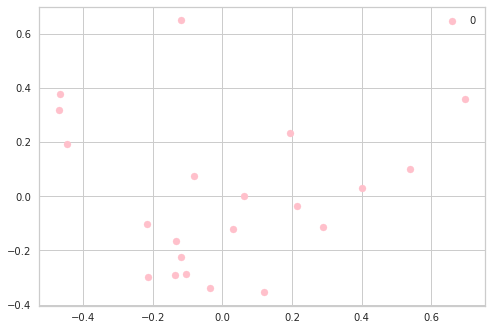

<Figure size 1440x720 with 0 Axes>

In [10]:
k=1
groups,model = cluster(df,features.keys(),k)
topTerms(model,df,k)
pcaColors(model,df)

In [11]:
for k in groups.keys():
    print(f'Group{k} =',groups[k])


Group0 = ['A68946', 'A02775', 'A12777', 'A08015', 'A18402', 'A18770', 'A19797', 'A71324', 'A02655', 'A14160', 'A06183', 'A18419', 'A10710', 'A00991', 'A68945', 'A02495', 'A05458', 'A08003', 'A00410', 'A19921', 'A04813']


In [12]:
for k in groups.keys():
    kWords = []
    tWords = []
    print(f'Group {k}')
    for TCPID in groups[k]:
        kWords.extend(list(kwdict[TCPID][0]))
        tWords.extend(topics[TCPID])
    print('Keywords: ',Counter(kWords).most_common(n=10))
    print('Topic words: ',Counter(tWords).most_common(n=20))

Group 0
Keywords:  [('Explorers', 2), ('Sir', 2), ('Drake Francis', 2), ('Biography', 2), ('West Indies Expedition', 2), ('Controversial literature', 2), ('America', 1), ('Pappe with an hatchet', 1), ('Lyly John', 1), ('Marprelate controversy', 1)]
Topic words:  [('good', 11), ('take', 10), ('great', 9), ('man', 9), ('out', 7), ('time', 6), ('place', 5), ('well', 5), ('day', 4), ('never', 4), ('many', 4), ('love', 4), ('yet', 4), ('captain', 3), ('ship', 3), ('god', 3), ('use', 3), ('general', 2), ('town', 2), ('sea', 2)]
